In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.281694 -0.042379  0.210555  0.571460  0.034592 -0.466718 -0.087278   
  1   0.515353 -0.661444  0.632490  0.114930  0.174150 -0.905192  0.331688   
  2  -0.059591 -0.250675  0.191867 -0.933595  0.385901 -0.323712  0.153621   
  3  -0.022931 -0.613580 -1.028479 -0.608853  0.367119  0.014052  0.484917   
  4   0.143659 -0.705778 -0.855391  0.137850 -0.250959 -0.615573  0.489998   
  5  -0.520209 -0.231192  0.421973  0.056323  0.193705 -0.888325  0.387956   
  6  -0.210591  0.080365  0.160638  0.002882 -0.175744  0.647675  1.201103   
  7  -0.357217  0.081085  0.081506  0.175573 -0.386187 -0.722147  0.924119   
  8  -0.773458 -0.641535 -0.043545  0.507492 -0.149820  0.180833 -0.329184   
  9  -0.407781 -0.167807  0.320331  0.117767 -0.499223 -0.092212 -0.653836   
  10 -0.278527 -0.458415  0.265890  0.356960 -0.165958 -0.741333  0.018795   
  11  0.897673  0.578851  0.216978  0.452690  1.315725  0.270293  0.546909   
  12 -0.391562  0.294694 -0.606250  0.013933 -1.049303 -0.037349 -0.156368   
  13 -0.566014  0.093935  0.252738  0.705979  0.232361  0.306750  0.390100   
  14  0.940916  0.797383 -0.399913  0.342203  1.403176 -0.336934  0.622920   
  15  0.220821  0.947996 -0.017943  0.528798  0.241778 -0.391851  0.477720   
  16  0.507740  1.047174  0.387275  0.498413 -0.159411 -0.257544 -0.361078   
  17 -0.139728  0.915510  0.259538 -0.411486 -0.457596 -1.220937  0.022883   
  18  0.370545  0.582123  0.984363  1.168777 -0.240144 -0.643299  0.828155   
  19  0.160247 -0.414885 -0.004614  1.257570  0.169374  0.112927 -0.270613   
  20  0.375655  0.050894 -0.290794  0.140759 -0.560092 -0.666846  0.009661   
  21  0.296280 -0.353514 -0.621040  1.030582  0.568600 -0.291319 -0.317719   
  22 -0.221741 -0.180198 -0.334978  0.291746 -0.198035 -0.678996 -0.052349   
  23 -0.102219  0.012119  0.651583  0.583490 -0.215122 -0.449220  0.023796   
  24  0.250632 -0.081377  0.115293  0.886306 -0.332849  0.406805 -1.139761   
1 0  -0.376147 -0.021000 -0.343068 -0.611429  0.150283  0.389235 -0.206021   
  1  -0.119449  0.265568 -0.968999  0.152227  0.542168 -0.027244  0.643275   
  2   0.336341 -0.318408  0.262419 -0.813039 -0.298593 -0.117196  0.372008   
  3   1.377941 -0.021529  1.397162  0.576727 -0.053318  0.705057  0.244525   
  4  -1.040747  1.000257  0.111508  0.230499 -0.749455 -0.365135 -0.004384   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.000849  0.299830  0.296836  ... -0.011594 -0.214181 -1.490883   
  1  -0.403548  0.285156 -0.825872  ... -0.176922  0.211074 -0.219531   
  2  -0.274141 -0.611749  0.263763  ... -1.172281  0.211658 -0.287230   
  3   0.298536  0.058253  0.211064  ... -0.959055  0.305697 -0.782514   
  4  -0.110084  1.107529 -0.293289  ...  0.751957  0.638688 -0.576001   
  5   0.293713  0.626366  0.444201  ...  0.708276  0.496080  0.449086   
  6   0.970733  0.688111  0.623997  ...  0.246101  0.446264 -0.299552   
  7   0.104077 -0.754312  0.372173  ... -1.126138 -0.610423 -1.206166   
  8   0.195373 -0.192147  0.059123  ...  1.419730  1.026301  0.667151   
  9  -0.315572 -0.126355 -0.547574  ...  0.881528  0.626778 -0.492288   
  10  0.123844 -0.095801 -0.628476  ... -0.494322  0.866539 -0.378950   
  11  0.760817  0.682957  0.417468  ...  0.710194  0.872513  0.964749   
  12 -0.730139  0.429632  0.245983  ...  0.114722  0.823817 -0.072297   
  13  1.162114 -0.145044 -0.090785  ... -0.132262  0.340231  0.407425   
  14 -0.205012  0.476424 -0.899775  ...  0.825174  0.758238 -0.255851   
  15  0.017349 -0.267203 -0.987855  ... -0.318583 -0.010613 -0.325390   
  16 -0.263550  0.226410  0.198294  ...  0.911230  1.082288  1.587366   
  17  0.079334 -0.311178 -0.252712  ...  0.224476  0.143939 -1.422647   
  18  0.753472  0.742992 -0.347251  ... -0.466631  0.764934 -0.953396   
  19 -0.441619  0.470845  0.046870  ... -0.992563  0.333333 -0.299220   
  20  0.403304  0.028598  0.427232  ...  0.156318  0.222278 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.046961  0.040074  26.125466  1.873139e-150  0.968417  1.125505


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



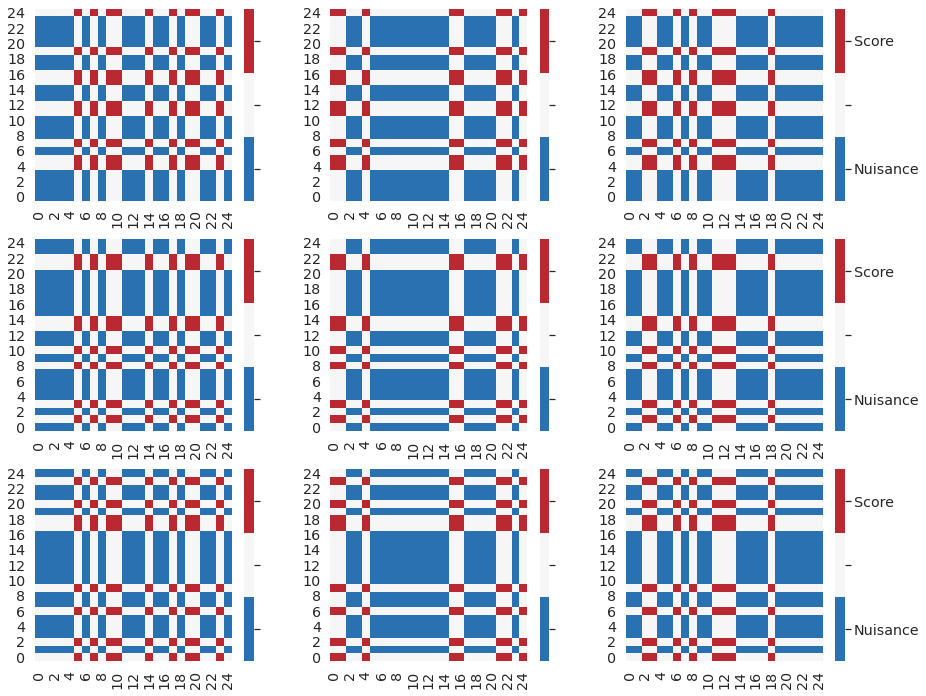

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



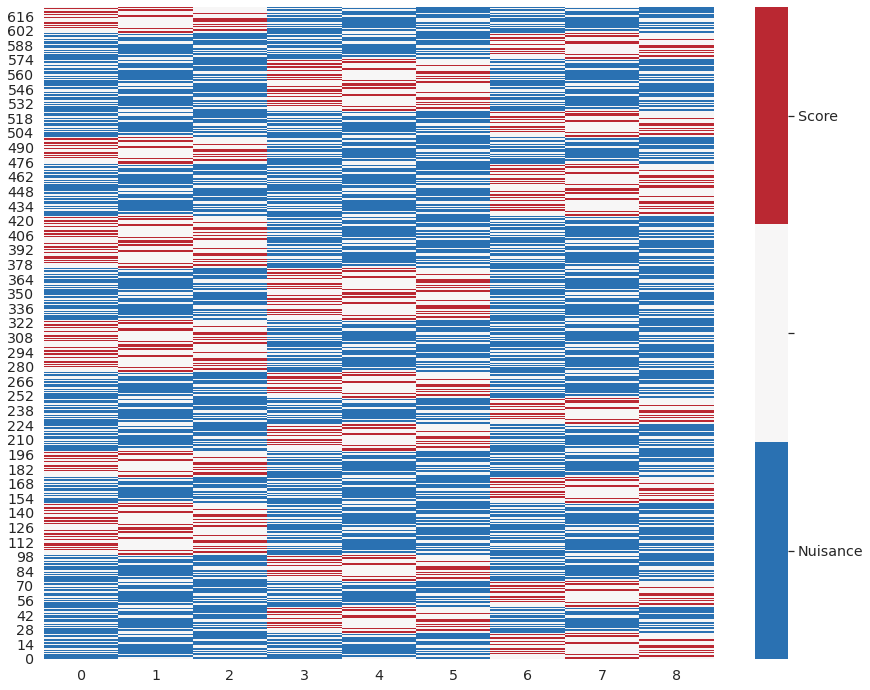

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])